# Predicting survival for the Kaggle Titanic dataset using logistic regression

The Titanic dataset appears to have become the "Hello World" of machine learning.  

I was feeling left out, not having a mention of it on my Github.

So here goes: A very quick and dirty approach with some prep of the dataset, but minimal tweaking of the model, to see what sort of performance can be had with a bare bones logistic regression classifier.

(spoiler alert)

...not bad: f-score 81%.

URL: https://www.kaggle.com/c/titanic/data

As an aside, some useful learning had here about good and bad ways to (try to) write values to a dataframe!

## 1) Import libraries

In [632]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 2) Get data

In [633]:
train = pd.read_csv('titanic_train.csv')

## 3) Exploratory data analysis

In [634]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [635]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [636]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


So, we have:
    
    Missing data
    Mix of floats, ints and strings

First, let's find out where our missing data is...

In [637]:
train.isnull().head() # True indicates null

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False


Let's make a heatmap to get a feel for how much each of our features are affected by missing data...

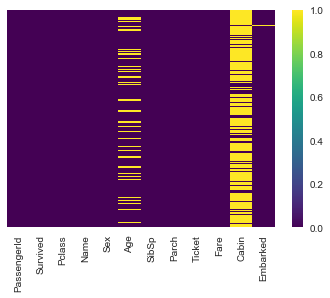

In [638]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=True, cmap='viridis') #yellow = true (missing data)

Missing some Age data, a lot of Cabin data, and one chunk of Embarked.

With the age, there looks to be plenty of data present to help me fill in gaps in some way, whereas in Cabin, there is just too much data missing, so might drop this.

Let's see how many passengers survived or died...

In [639]:
sns.set_style('whitegrid')

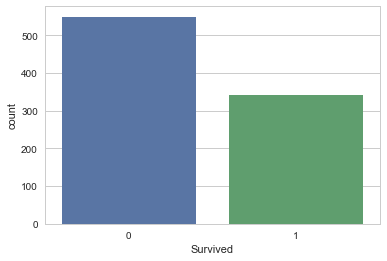

In [640]:
sns.countplot(train.Survived) # countplot = hist

We can see that the majority of passengers in our training set died.

Let's see this plot separated by sex...

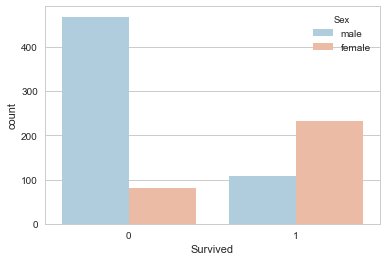

In [641]:
sns.countplot(x='Survived', hue='Sex', data=train, palette='RdBu_r')

From the above we see that males were much more likely to die. 

And now let's see the same data split by class

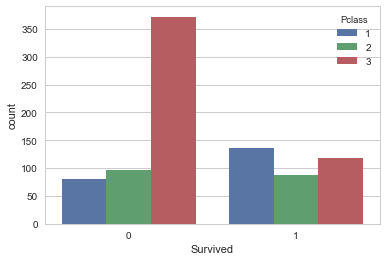

In [642]:
sns.countplot(x='Survived', hue='Pclass', data=train)

From the above we see that 3rd class passengers were far more likely to have died.

Let's see a distribution of passengers by age...

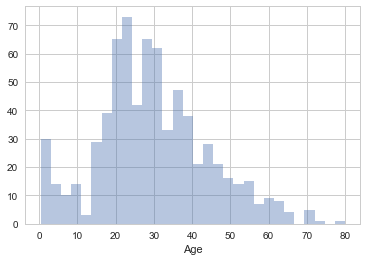

In [643]:
sns.distplot(train.Age.dropna(), kde=False, bins=30)

From the above, we see an almost bimodal distribution, with what seems like a peak for very young children and a second peak between 20 and 30.  The distribution is skewed to the right (increasing age).

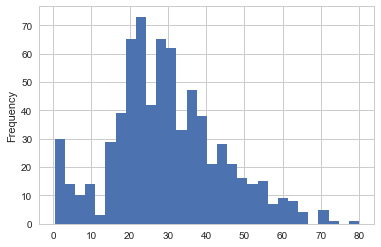

In [644]:
train.Age.plot.hist(bins=30)  
#Can also create plot straight from pandas - doesn't provide x axis ??

In [645]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Let's have a closer look at SibSp - number of siblings or spouse on board

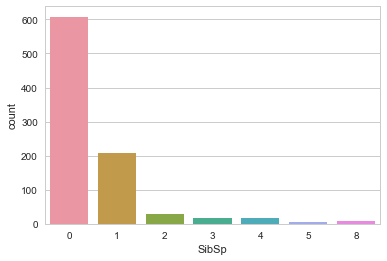

In [646]:
sns.countplot(train.SibSp) # most people did not have children or a spouse on board

From the above we see that most people did not have a sibling or spouse on board.  There were a lot of single people on board (men in 3rd class?)

Let's see a ditribution of what people paid for their ticket...

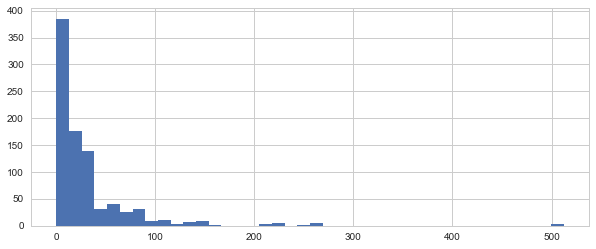

In [647]:
train.Fare.hist(bins=40, figsize=(10,4))

Wide range (long tailed) of values. Most people paid for a cheaper fare (remember a lot of single travellers!) 

## 4) Prep data

### Missing values - impute values or drop data

This is our heatmap from earlier illustrating missing data

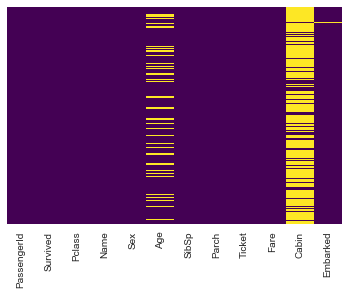

In [648]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Instead of imputing average age for the entier dataset, it seems like we have enough data to impute with greater granularity, for example by stratifying across class. This is likely to allocate more 'realistic' averages. 

Let's see how age relates to class...

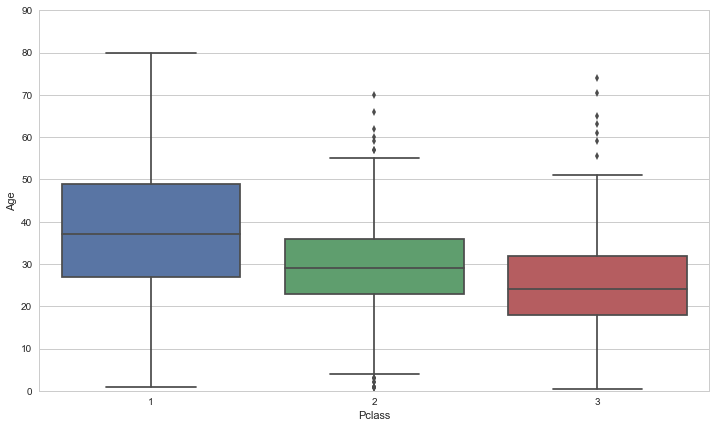

In [649]:
plt.figure(figsize=(12,7))
plt.ylim(0,90)

sns.boxplot(x='Pclass', y ='Age', data= train)

From the above, we see that there are clearly different average ages for each class.

Let's also use violinplot to visualise the distributions for each class...

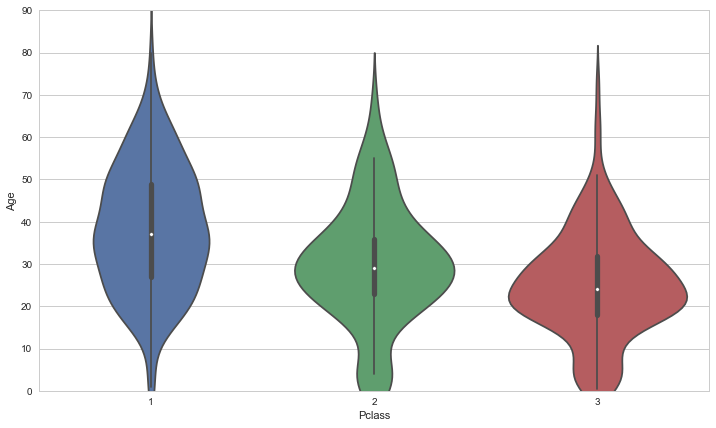

In [650]:
plt.figure(figsize=(12,7))
plt.ylim(0,90)

sns.violinplot(x='Pclass', y ='Age', data= train)

Distributions look for the most part normal but with a long tail effect skewing to higher age - most pronounced in 3rd class (poorer people ..shorter lifespan).  Despite the skew, age averages stratified by class will still be better than using one average.  Let's etsablish mean ages then create a function to impute ages by class...

In [651]:
pclass_stratified_means=train.groupby('Pclass').mean()
pclass_stratified_means

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550


In [652]:
def impute_age_train(cols):
    """
    cols is a list of args, supplying Age and Pclass.
    Function identifies null fields and returns average age,
    where the average values are stratified by class.    
    """
    Age=cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        return pclass_stratified_means.loc[Pclass].Age
    
    else:
        return Age

In [653]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


PassengerID = 6 is in Pclass = 3 so should have Age = NaN replaced with 25.14

In [654]:
train.Age = train[['Age', 'Pclass']].apply(impute_age_train, axis=1)
train.Age.head(10)

0    22.00000
1    38.00000
2    26.00000
3    35.00000
4    35.00000
5    25.14062
6    54.00000
7     2.00000
8    27.00000
9    14.00000
Name: Age, dtype: float64

We have resolved missing values for age.  Let's look at heatmap again...

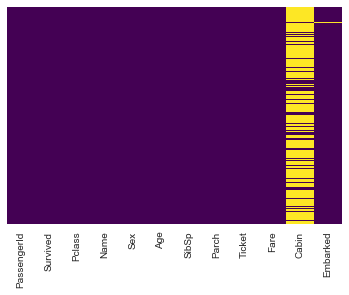

In [655]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Cabin may well contain useful information.  It may give specific information about the location of the cabin on the boat which relates to the likelihood of an individual surviving or dying.  

However, there is so much information missing that this could require a lot of work.  For our quick and easy approach, we will drop this column altogether. 

In [656]:
train.drop('Cabin', axis=1, inplace=True)

In [657]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S


We still have missing data for Embarked left to deal with.  Let's call .info() to see how many null values there are...

In [658]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 76.6+ KB


There are only two datpoints with missing data.  Let's just drop these.  We can just use command .dropna() on entire df now... 

In [659]:
train.dropna(inplace=True)

In [660]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


We have 889 entries now, all non-null.  

We still have mixed data types, i.e strings. Let's look at any of these which represent categorical variables... 

### Categorical features - dummy variables

We need to convert any column that contains categorical (string or numbers acting as strings) data into a form that is useable by the algorithm.  What this means is refactoring a single column (i.e. a specific feature) containing _n_ categories into multiple (_n-1_) columns.


Example: 

A column such as 'T_shirt_size' where each example is categorised as S, M or L, needs to be split into 3-1=2 columns, called for example S and M.  We refer to these new features as dummies - the columns contain dummy variables

We drop 1 column to avoid multicolinearity, where redundant information means that it is impossible for a learning algorithm to trace causative influence on target back to one feature.  (Consider how we would identify whether x1 or x2 is cause of y's value when x1 + x2 = c.)

Important to be alert to the issue that categories can sometimes masquerade as numbers.  We might categorise some variable using 1, 2 or 3 where there is no numerical relevance/order/value.  If the numbers can be replaced with a, b, c then you have a categorical variable.   

From our .info() above, we see that we hav strings for 'Sex', 'Embarked', 'Name' and 'Ticket'

Dummy variables are needed for 'Sex' and 'Embarked' and it makes sense to drop 'Name' and 'Ticket' as it isn't easy to see how they might offer useful info.  

Let's create dummy variables for 'Sex' and embarked.  

**Approach:**

    i) Create separate dataframe for variable you want to separate into dummies
        (There may be multiple cols you want to do this for, in which case you'll create multiple dfs)
    ii) Use pd.concat to join the 1 or more new dfs to your existing
        (If you want new ones first, reverse order of args in pd.concat() )
    iii) Drop the columns for which you have created dummies  

Create separate a dataframe for each variable that we want to  create dummy variables for...  

In [661]:
sex = pd.get_dummies(train.Sex, drop_first=True) #drop first to avoid multicolinearity due to redundant data.
sex.head()
# Note pandas takes care of column headings using the original category labels

,male
0,1
1,0
2,0
3,0
4,1


In [662]:
embarked = pd.get_dummies(train.Embarked, drop_first=True)
embarked.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


Concatenate to end of original dataframe...

In [663]:
train= pd.concat([train,sex,embarked], axis=1) # swap args order if need to prepend rather than append
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,0,1


Drop the original variables from which we have created dummies (and anything else we want to drop, in this case, Ticket and Embarked)...

In [664]:
train.drop(['Name','Sex','Ticket','Embarked'], axis=1, inplace=True)
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


Passenger ID is not really giving us any info that would be useful to learn from.  It's not, for example an order of booking, so let's drop that also... 

In [665]:
train.drop(['PassengerId'], axis=1, inplace=True)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


**Note:** <br>
We observe that Pclass values are ints, but these  values actually represent categories and unless there is some numerical relationship betwen the values that an algorithm could utilise, they may be better expressed as categories.  It's also the case that we might be incorporating redundant information.  For now, we'll leave them as is and then later compare performance after we convert to dummy variables.



### Training and test sets

All the above data prep has been on our training set.

Let's do the same prep for our test set...

In [666]:
test = pd.read_csv('titanic_test.csv')

In [667]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


We have the question now of what to do about missing values in the test set where we intend to impute mean.

Typically, you might determine means for entire dataset (and do all data prep) prior to splitting.

Here our data is already separated.  We can either:
    
    i) impute using means determined from train data
    ii) impute using means from test data
    
Given the assumption that the 2 datasets are large and from the same population option i should be fine, but given that we have the test data and can readily determine 'true' sample means let's do so...

Determine stratfied means for our test data...

In [668]:
pclass_stratified_means_test = test.groupby('Pclass').mean()
pclass_stratified_means_test

,PassengerId,Age,SibSp,Parch,Fare
Pclass,,,,,
1,1098.224299,40.918367,0.476636,0.383178,94.280297
2,1117.935484,28.777500,0.376344,0.344086,22.202104
3,1094.178899,24.027945,0.463303,0.417431,12.459678


These are pretty similar to our training set Age means.

Impute means (note our modified function calls the *test* means rather than the *train* means)...

In [669]:
def impute_age_test(cols):
    """
    cols is a list of args, supplying Age and Pclass.
    Function identifies null fields and returns average age,
    where the average values are stratified by class.    
    """
    Age=cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        return pclass_stratified_means_test.loc[Pclass].Age
    
    else:
        return Age

In [670]:
test.Age = test[['Age', 'Pclass']].apply(impute_age_test, axis=1)

Create dummy variable dfs from categorical...

In [671]:
sex = pd.get_dummies(test.Sex, drop_first=True)
embarked = pd.get_dummies(test.Embarked, drop_first=True)

Append dummy variable dfs back to original (test) df... 

In [672]:
test = pd.concat([test, sex, embarked], axis=1)

Drop original categorical variables and also drop the same fetaures that we dropped for training set...

In [673]:
test.drop(['Name','Sex','Ticket','Embarked', 'Cabin','PassengerId' ], axis=1, inplace=True)

Check for missing data...

In [674]:
test.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
Pclass    418 non-null int64
Age       418 non-null float64
SibSp     418 non-null int64
Parch     418 non-null int64
Fare      417 non-null float64
male      418 non-null uint8
Q         418 non-null uint8
S         418 non-null uint8
dtypes: float64(2), int64(3), uint8(3)
memory usage: 17.6 KB


From the above we see that we have a missing value for Fare.  Let's find the location...

In [675]:
test.Fare[test.Fare.isnull()]

152   NaN
Name: Fare, dtype: float64

Instead of using _.apply()_ + _function_ to iterate through every value in column let's just modify this one value manually with the stratified mean that we determined in pclass_stratified_means_test df (12.459678 for Pclass=3)...

First, we demonstrate the **wrong** way to set a df value (writing to a chained index)...

In [676]:
test.iloc[152]['Fare'] = pclass_stratified_means_test.loc[3]['Fare']
test.iloc[152]

/home/fluff/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Pclass     3.0
Age       60.5
SibSp      0.0
Parch      0.0
Fare       NaN
male       1.0
Q          0.0
S          1.0
Name: 152, dtype: float64

### **IMPORTANT:**
** Do not use chained indexing of df to write a cell!** <br>
<br>
** Use *df.set\_value('row_ID', 'col_ID', val)*.**
<br>

Now using the correct way to set a value in df...

In [677]:
test.set_value(152, 'Fare',  pclass_stratified_means_test.loc[3]['Fare'] )
test.iloc[152] # Fare should now read 12.459678

Pclass     3.000000
Age       60.500000
SibSp      0.000000
Parch      0.000000
Fare      12.459678
male       1.000000
Q          0.000000
S          1.000000
Name: 152, dtype: float64

Quick check that head matches for train and test...

In [678]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


In [679]:
test.head()

,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,3,34.5,0,0,7.8292,1,1,0
1,3,47.0,1,0,7.0000,0,0,1
2,2,62.0,0,0,9.6875,1,1,0
3,3,27.0,0,0,8.6625,1,0,1
4,3,22.0,1,1,12.2875,0,0,1


Ah....
Just realised something that should have been fairly obvious.  Kaggle test set has no target data.

Let's go back to our training set and split that instead.

In [680]:
X = train.drop('Survived', axis=1)

y = train['Survived']

In [681]:
from sklearn.model_selection import train_test_split

In [682]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## 5) Create model

In [683]:
from sklearn.linear_model import LogisticRegression

In [684]:
lrmodel = LogisticRegression()

In [685]:
lrmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [686]:
y_pred = lrmodel.predict(X_test)

## 6) Evaluate model 

In [687]:
from sklearn.metrics import confusion_matrix, classification_report

In [688]:
print(confusion_matrix(y_test, y_pred))

[[148  15]
 [ 36  68]]


 There are 163 Class 0 (died). <br>
There are 104 Class 1 (survived).

For actual class 0 the model correctly captures 148 of the class 0 (died) and misclassifies 15 of the class 0 (died) as survived - 15 false positives. <br>
For actual class 1 the model correctly predicts the class for 68 of the survivors but incorrectly labels 36 survivors as died. <br>
<br>
Total misclassifications = 51/269 = 0.19 misclassification rate so not terrible but could hopefully be improved.

In [689]:
from sklearn.metrics import accuracy_score
print('Misclassification rate: {:.2f}'.format(1-accuracy_score(y_test, y_pred)))

Misclassification rate: 0.19


In [690]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.80      0.91      0.85       163
          1       0.82      0.65      0.73       104

avg / total       0.81      0.81      0.80       267



Recall for class 0 (died) is good, and quality is not bad with precision at 0.8 due to misclassifying 15 died as survivors.

Recall for class 1 (survived) is less inspiring, only finding 68 of the 104 survivors (0.65).  Of those identified as survivors, precision is not bad.  15 actual died are pulled in.  

## 7) Rebuild and revaluate for Pclass converted to dummy variables

Previously, we did not deal with the Pclass being categorical data.  Let's convert to dummy variables, run model again and see what if any improvement there is...

In [691]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


In [692]:
pclass = pd.get_dummies(train.Pclass, drop_first=True)
pclass.head()

,2,3
0,0,1
1,0,0
2,0,1
3,0,0
4,0,1


In [693]:
train = pd.concat([train, pclass], axis=1)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S,2,3
0,0,3,22.0,1,0,7.2500,1,0,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1,0,1
3,1,1,35.0,1,0,53.1000,0,0,1,0,0
4,0,3,35.0,0,0,8.0500,1,0,1,0,1


In [694]:
train.drop('Pclass', axis=1, inplace=True)

In [695]:
train.head()

,Survived,Age,SibSp,Parch,Fare,male,Q,S,2,3
0,0,22.0,1,0,7.2500,1,0,1,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,0,1,0,1
3,1,35.0,1,0,53.1000,0,0,1,0,0
4,0,35.0,0,0,8.0500,1,0,1,0,1


In [696]:
X = train.drop('Survived', axis=1)
y = train.Survived

In [697]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # same seed as prev

In [698]:
lrmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [699]:
y_pred = lrmodel.predict(X_test)

In [700]:
print(confusion_matrix(y_test,y_pred))

[[149  14]
 [ 36  68]]


In [701]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.81      0.91      0.86       163
          1       0.83      0.65      0.73       104

avg / total       0.81      0.81      0.81       267



In [702]:
from sklearn.metrics import accuracy_score
print('Misclassification rate: {:.2f}'.format(1-accuracy_score(y_test, y_pred)))

Misclassification rate: 0.19


So converting the Pclass to dummy variables has made little difference.  One example that had previously been classed as a false positive (actual died, predicted survived) has now been correctly predicted as a negative (died) giving marginal increase in class 0 precision and coresponding marginal (1%) increase in f score.